In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))
from utils.loading import load_net
from utils.data import make_generators_DF_cifar
from utils.display import torch_to_np, show_imgs
from models.generative_classify import optimize_latent_cvae, generative_classify_cvae, optimize_latent, generative_classify

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torch.nn import functional as F
import torch.optim as optim

import foolbox
import json
from PIL import Image

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.current_device())

cuda:1
0


In [2]:
def VAE_test_loss(recon_x, mu, logsigma, x, KLD_weight=1):    
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
    loss = BCE+KLD_weight*KLD
    return loss, BCE, KLD
    
def optimize_latent_tmp(imgs, mu, logvar, model, lr=.001, iterations=50, KLD_weight=1):
    BCE_list = []
    KLD_list = []
    
    model=model.eval()
    
    for p in model.parameters():
        p.requires_grad=False
        
    optimizer = optim.Adam([mu, logvar], lr=lr)

    for i in range(iterations):
        z = model.reparameterize(mu, logvar)
        recon_x = model.decode(z)

        loss, BCE, KLD = VAE_test_loss(recon_x, mu, logvar, imgs, KLD_weight)
        BCE_list.append(BCE.item())
        KLD_list.append(KLD.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return recon_x, z, loss, BCE_list, KLD_list

In [3]:
files_df_loc = '/media/rene/data/adv_consistency/MNIST/mnist_normal/files_df.pkl'
with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

img_path = files_df['val'].iloc[5]['path']
img_label = files_df['val'].iloc[5]['class']

num = 10
latent_size = 16

transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

Label:  0 Loss:  799.0052490234375 KLD:  65.01919555664062


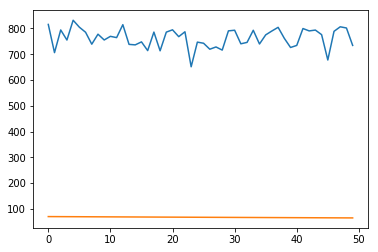

Label:  1 Loss:  812.7410278320312 KLD:  59.45455551147461


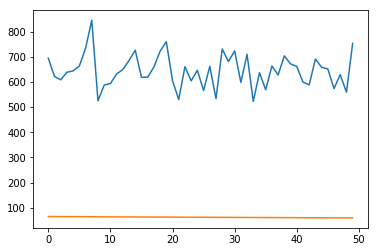

Label:  2 Loss:  790.5794067382812 KLD:  54.65372085571289


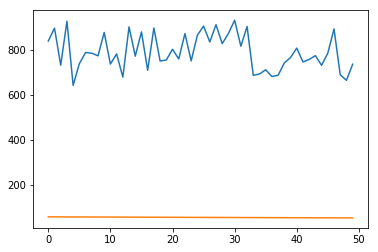

Label:  3 Loss:  865.3911743164062 KLD:  50.23419952392578


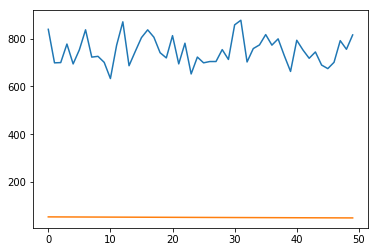

Label:  4 Loss:  840.849853515625 KLD:  46.53779983520508


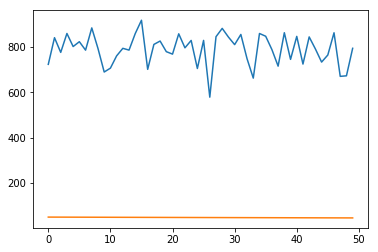

Label:  5 Loss:  858.364013671875 KLD:  42.853519439697266


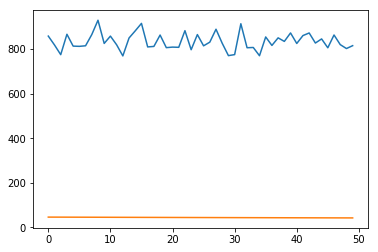

Label:  6 Loss:  835.5886840820312 KLD:  39.919490814208984


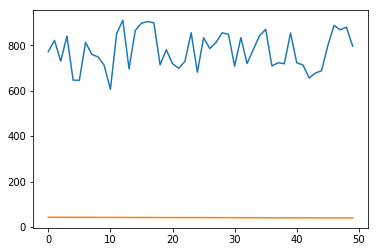

Label:  7 Loss:  881.5752563476562 KLD:  37.551597595214844


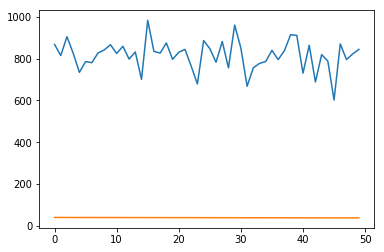

Label:  8 Loss:  779.5301513671875 KLD:  35.084835052490234


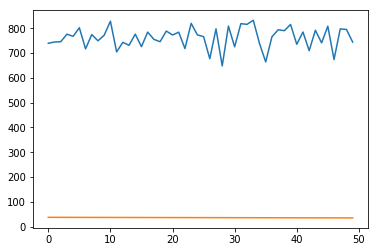

Label:  9 Loss:  941.9183959960938 KLD:  32.760807037353516


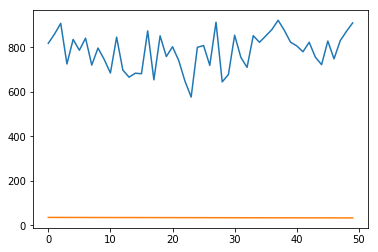

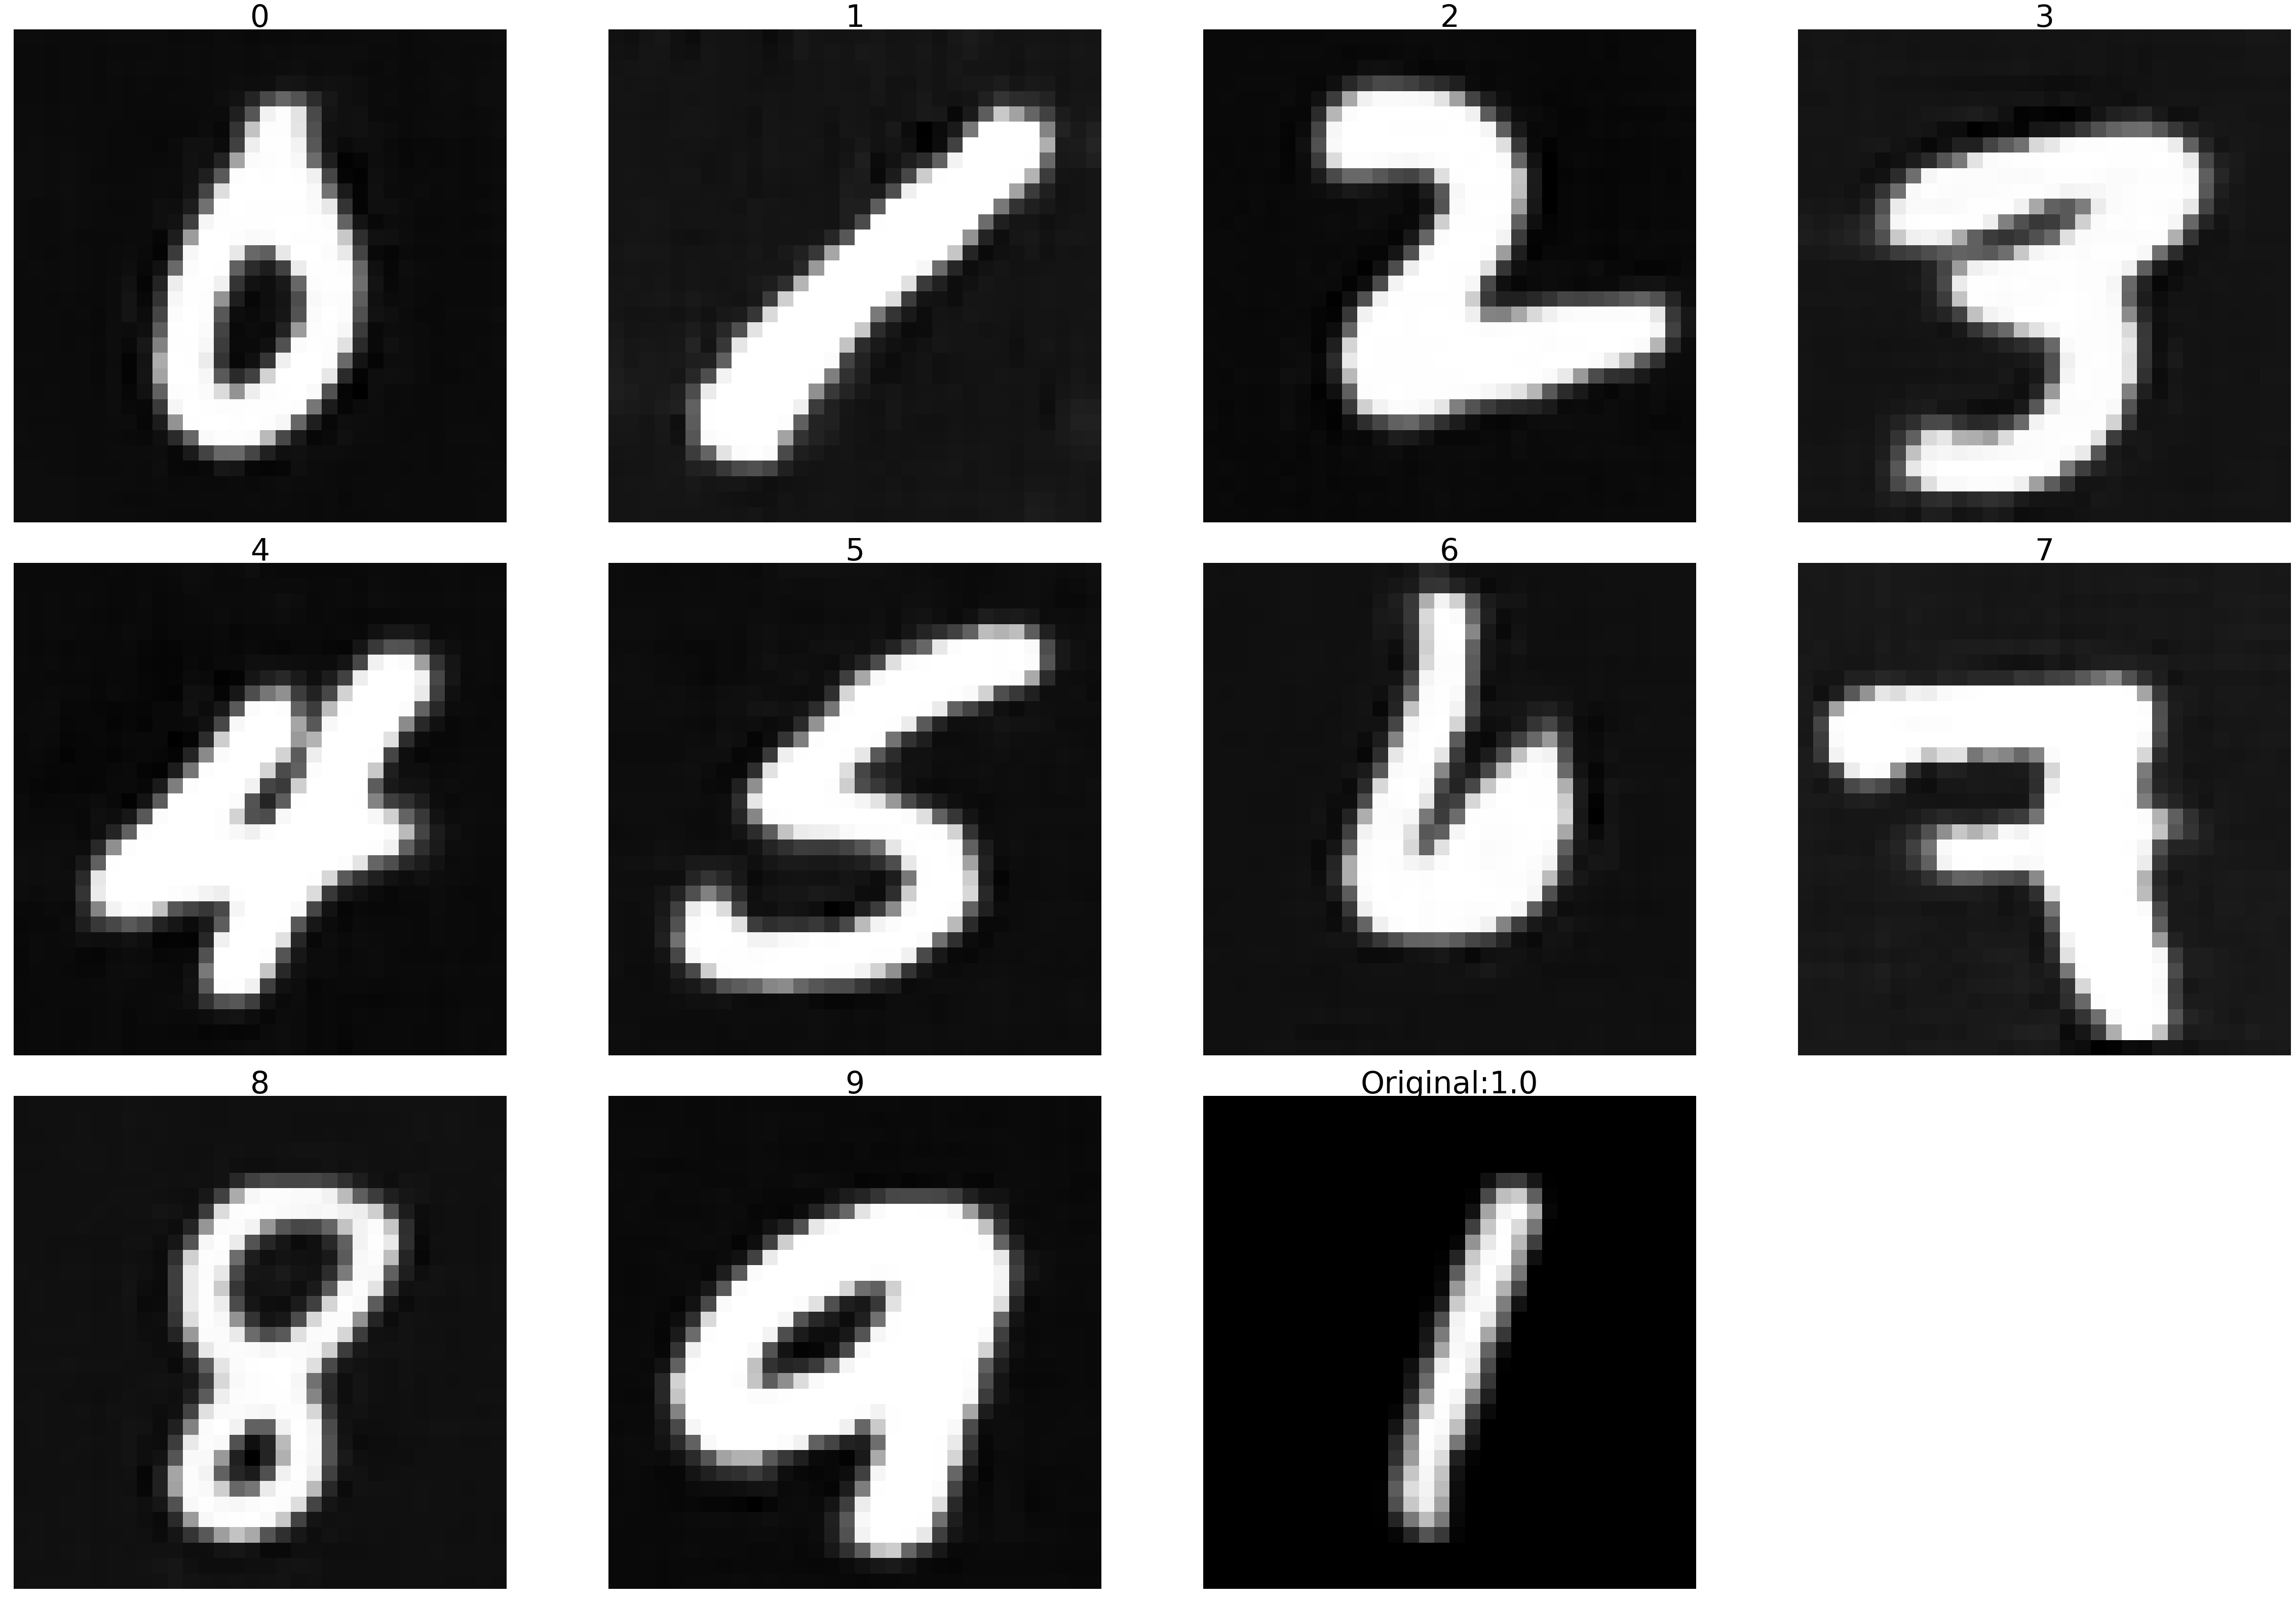

In [4]:
with torch.cuda.device(1):
    save_path = Path('/media/rene/data/adv_consistency/MNIST/mnist_normal/models/')
    model_list = []
    all_recon = []
        
    rand_mu = np.random.normal(0,1, (1, latent_size))
    rand_logvar = np.random.normal(0,1, (1, latent_size))
    mu = torch.tensor(rand_mu, device=device, requires_grad=True).type(torch.cuda.FloatTensor)
    logvar = torch.tensor(rand_logvar, device=device, requires_grad=True).type(torch.cuda.FloatTensor)
    mu = Variable(mu.data, requires_grad=True)
    logvar = Variable(logvar.data, requires_grad=True)
    
    for label in range(num):
        model_name = 'VAE-1_16_32_64-16-MNIST_label_'+str(label)+'_model_best.pth.tar'
        model_loc = save_path / model_name
        model = load_net(model_loc).to(device).eval()

        recon_x, z, loss, BCE_list, KLD_list = optimize_latent_tmp(tensor_img, mu, logvar, model)
        print('Label: ',  label, 'Loss: ', loss.item(), 'KLD: ',KLD_list[-1])
        x = list(range(50))
        plt.plot(x, BCE_list)
        plt.plot(x, KLD_list)
        plt.show()
        
        all_recon.append(torch_to_np(recon_x))

original = torch_to_np(tensor_img)
labels = np.array(list(range(num))+['Original:'+str(img_label)])
show_imgs(np.array(all_recon+[original]), labels, cols = 3)

In [11]:
def loss_function(recon_x, mu, logsigma, x):    
    print('logsigma.requires_grad', logsigma.requires_grad)
    print('mu.requires_grad', mu.requires_grad)
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
    loss = BCE+KLD
    return loss, BCE, KLD

In [4]:
def loss_function(recon_x, mu, logsigma, x):    
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
    loss = BCE+KLD
    return loss, BCE, KLD

In [12]:
files_df_loc = '/media/rene/data/adv_consistency/MNIST/mnist_normal/files_df.pkl'
with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

img_path = files_df['val'].iloc[5]['path']
img_label = files_df['val'].iloc[5]['class']

num = 10
latent_size = 16

transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

lr=.001
iterations = 100



save_path = Path('/media/rene/data/adv_consistency/MNIST/mnist_normal/models/')
model_list = []
all_recon = []

rand_mu = np.random.normal(0,1, (1, latent_size))
rand_logvar = np.random.normal(0,1, (1, latent_size))

mu = torch.tensor(rand_mu, device=device, requires_grad=True).type(torch.cuda.FloatTensor)
logvar = torch.tensor(rand_logvar, device=device, requires_grad=True).type(torch.cuda.FloatTensor)
mu = Variable(mu.data, requires_grad=True)
logvar = Variable(logvar.data, requires_grad=True)


# rand_mu = torch.as_tensor(rand_mu, dtype=torch.float64, device=device)
# logvar = torch.as_tensor(logvar, dtype=torch.float64, device=device)

model_name = 'VAE-1_16_32_64-16-MNIST_label_'+str(0)+'_model_best.pth.tar'
model_loc = save_path / model_name
model = load_net(model_loc).to(device).eval()

model=model.eval()

optimizer = optim.Adam([mu, logvar], lr=lr)

BCE_list = []
KLD_list = []

for i in range(iterations):
    z = model.reparameterize(mu, logvar)
    recon_x = model.decode(z)

    loss, BCE, KLD = loss_function(recon_x, mu, logvar, tensor_img)
    BCE_list.append(BCE.item())
    KLD_list.append(KLD.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()